In [41]:
import import_ipynb
import matplotlib.pyplot as plt
import NLP_preprocessing as pre
import numpy as np
import re
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim as gensimvis

from gensim import corpora
from gensim.models import *
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from tqdm import tqdm

In [2]:
%matplotlib inline

In [65]:
positive = pd.read_csv('positive.csv', sep = ';', usecols = [3], names = ['text'])
positive['label'] = ['positive'] * len(positive)

negative = pd.read_csv('negative.csv', sep = ';', usecols = [3], names = ['text'])
negative['label'] = ['negative'] * len(negative)

In [66]:
df = pd.concat([positive, negative], ignore_index = True)
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226834 entries, 0 to 226833
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [68]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(pre.text_preprocess_light)

100%|█████████████████████████████████████████████████████████████████████████| 226834/226834 [05:07<00:00, 736.97it/s]


In [69]:
for i in range(len(df['text'])):
    df['text'][i] = df['text'][i].split() 

In [70]:
# Словарь уникальных токенов
dictionary = corpora.Dictionary(df['text'])

In [71]:
# Выкидывание редких слов
dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None)
dictionary.save('tweet.dict')
len(dictionary.keys())

12328

In [72]:
# Векторизация твитов
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('tweet.model', corpus)

In [73]:
# Обработка словаря
mm = corpora.MmCorpus('tweet.model')
print(df['text'].values[0])
print(mm[0])

['школотый', 'поверь', 'самый', 'общество', 'профилировать', 'предмет', 'тип']
[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0)]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [29:48<00:00, 255.53s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

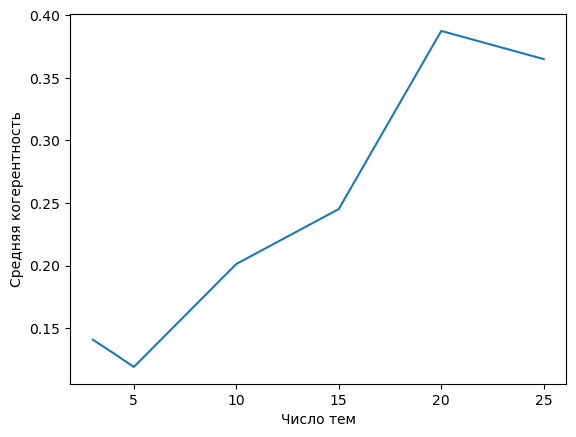

In [63]:
topic_list = [3,4,5,10,15,20,25]
coherences = []

for num in tqdm(topic_list):
    lda = ldamodel.LdaModel(corpus, 
                            id2word=dictionary, 
                            num_topics=num, 
                            chunksize=50, 
                            update_every=1, 
                            passes=2)
    coherences.append(CoherenceModel(model=lda, 
                                     texts=df['text'], 
                                     dictionary=dictionary, 
                                     coherence='c_v').get_coherence())
plt.plot(topic_list, coherences)
plt.xlabel('Число тем')
plt.ylabel('Средняя когерентность')
plt.show
    

In [91]:
# Обучение модели
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=3)

In [92]:
# Определяем тематики
lda.show_topics(num_topics=3, num_words=20, formatted=True)

[(0,
  '0.018*"завтра" + 0.016*"хотеть" + 0.012*"школа" + 0.012*"спать" + 0.010*"дом" + 0.010*"идти" + 0.010*"блин" + 0.009*"час" + 0.009*"болеть" + 0.009*"вообще" + 0.008*"утро" + 0.007*"пойти" + 0.007*"скучать" + 0.007*"плохо" + 0.006*"настроение" + 0.006*"работа" + 0.006*"урок" + 0.006*"ночь" + 0.006*"делать" + 0.006*"сидеть"'),
 (1,
  '0.017*"немочь" + 0.010*"нехотеть" + 0.010*"незнать" + 0.010*"знать" + 0.009*"думать" + 0.008*"никто" + 0.008*"писать" + 0.007*"блин" + 0.007*"какой" + 0.007*"вообще" + 0.007*"небыть" + 0.006*"жаль" + 0.006*"говорить" + 0.005*"делать" + 0.005*"бля" + 0.004*"написать" + 0.004*"мой" + 0.004*"нельзя" + 0.004*"понимать" + 0.004*"простить"'),
 (2,
  '0.020*"хотеть" + 0.010*"новый" + 0.010*"любить" + 0.009*"самый" + 0.009*"мой" + 0.008*"друг" + 0.007*"любимый" + 0.007*"ждать" + 0.007*"хороший" + 0.006*"человек" + 0.006*"смотреть" + 0.006*"экзамен" + 0.005*"стать" + 0.005*"фильм" + 0.005*"ужасно" + 0.005*"обидно" + 0.004*"закончиться" + 0.004*"последний" + 0

#### Оценка качества модели

In [93]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0002094213849412541


In [94]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.11369465772266625


#### Визуализация

In [96]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.265975  0.181718       1        1  34.560408
1     -0.025912 -0.318986       2        1  33.317037
2      0.291887  0.137268       3        1  32.122555, topic_info=           Term          Freq         Total Category  logprob  loglift
168      завтра   6965.000000   6965.000000  Default  30.0000  30.0000
86       немочь   6244.000000   6244.000000  Default  29.0000  29.0000
98       хотеть  13012.000000  13012.000000  Default  28.0000  28.0000
569       спать   4490.000000   4490.000000  Default  27.0000  27.0000
171       школа   4618.000000   4618.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
662   последний   1571.542215   2643.503940   Topic3  -5.4087   0.6156
24   посмотреть   1299.947139   2053.414182   Topic3  -5.5984   0.6784
470       такой   1459.315489   2887.386312   Topic3  -5.4827   0.4532
404        день   1478.522641   3463.575044   Topic3  -5.4697   0.2844
56         один   1375.166978   3345.454387   Topic3  -5.5421   0.2466

[194 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1935      3  0.999426   бесить
21        1  0.577490     блин
21        2  0.422492     блин
27        1  0.326758      бля
27        2  0.665129      бля
...     ...       ...      ...
2997      2  0.001104   шерлок
2997      3  0.998696   шерлок
171       1  0.990008    школа
171       3  0.009744    школа
548       3  0.999369  экзамен

[295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [ ]:
pyLDAvis.display(vis)

In [ ]:
Темы:
    1. Рабочие будни;
    2. Действия;
    3. Отношения.